# Dependencies

In [1]:
import numpy as np
import pandas as pd
import os
import re
from concurrent.futures import ThreadPoolExecutor

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from scipy.interpolate import PchipInterpolator

from tqdm import tqdm

In [2]:
def drop_rows_with_nan(df, how='any', subset=None):
    """
    Removes rows containing NaN values from a Pandas DataFrame.

    Args:
        df: The Pandas DataFrame to process.
        how: 'any' to drop rows containing *any* NaN values, 'all' to drop only rows where *all* values are NaN.
        subset: An optional list of column names to consider. If None, all columns are checked.

    Returns:
        pandas.DataFrame: A new DataFrame with the NaN-containing rows removed.
                          The original DataFrame is not modified.
    """
    # Create a copy to avoid modifying the original DataFrame
    df_cleaned = df.copy()
    df_cleaned = df_cleaned.dropna(axis=0, how=how, subset=subset)
    return df_cleaned

# Working on...

In [3]:
# Specify the directory path
dir_path = "../files/data/RAW"

# Get folder names
master_folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]

print(master_folders)

# Specify the directory path
dir_path = "../files/data/RAW/{}".format(master_folders[4])

# # Get folder names
# folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]

# Get folder names that start with "DOUBLE_"
folders = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f)) and f.startswith('DOUBLE_')]

print(folders)

['FA7000-15-D-0006-19FA202', 'BH_SINGLE', 'FA700021D0002-23F0143', 'FA7000-15-D-0006-0016', 'FA7000-15-D-0006-9011', 'FA700021D0002-22F0214', 'TWIN', 'FA7000-15-D-0006-20F0212']
['DOUBLE_DATABASES_Rt1d0_8Mar2019', 'DOUBLE_DATABASES_Rt2d0_3Apr2019', 'DOUBLE_DATABASES_Rt1d5_8May2019', 'DOUBLE_DATABASES_Rt0d5_17Sep2019', 'DOUBLE_DATABASES_Rt2_3Apr2019', 'DOUBLE_DATABASES_Rt5d0_17Sep2019', 'DOUBLE_DATABASES_Rt3d0_8May2019', 'DOUBLE_DATABASES_8Mar2019']


# .DAT to .csv

In [4]:
def process_file(file_info):
    input_file_path, output_file_path = file_info
    
    rows = []
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        W_R, a_c, a_t, r_t, b_t = None, None, None, None, None
        c_index = 0

        for i, line in enumerate(lines):
            values = line.strip().split()
            if not values:
                continue
            
            if values[0] == "Geometry:":
                crack = False
                # Extract the coefficient multiplying R (which is W/R)
                wr_match = re.search(r"W=h=\s*([\d.]+)\*R", line)
                if wr_match:
                    W_R = float(wr_match.group(1))

                # Extract b/t value
                bt_match = re.search(r"with\s*b/t=([\d.]+)", line)
                if bt_match:
                    b_t = float(bt_match.group(1))

            if values[0] == "Scenario:":
                crack = False
                c_index = values[1]

            elif values[0] == "ndom" and (values[1] == "a1/c1" or values[1] == "a2/c2"):
                crack = False
                next_values = lines[i + 1].strip().split()
                a_c, a_t, r_t = map(float, next_values[1:4])

            elif values[0] == "crack":
                crack = True

            elif values[0].isdigit() and crack:
                row = [c_index] + list(map(float, values[0])) + [W_R, a_c, a_t, r_t, b_t] + list(map(float, values[5:9]))
                rows.append(row)

    df = pd.DataFrame(rows, columns=['c_index', 'crack', 'W/R', 'a/c', 'a/t', 'r/t', 'b/t', 'phi', 'K-T', 'K-B', 'K-P'])
    df.to_csv(output_file_path, index=False)

master_folder = master_folders[4]
tasks = []

for folder in folders:
    dir_path = os.path.join("../files/data/RAW", master_folder, folder)
    files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

    for file_name in files:
        input_file_path = os.path.join(dir_path, file_name)
        output_file_path = os.path.join(dir_path, f"{file_name[:-6]}.csv")
        tasks.append((input_file_path, output_file_path))


for i in tqdm(range(len(tasks))):
    process_file(tasks[i])

# with ThreadPoolExecutor() as executor:
#     list(tqdm(executor.map(process_file, tasks), total=len(tasks), desc="Processing Files"))

100%|██████████| 155/155 [3:34:33<00:00, 83.06s/it]  


In [ ]:
# Specify the directory path
dir_path = "../files/data/TWIN/CS"

# Get all .csv files
csv_files = [f for f in os.listdir(dir_path) if f.endswith(".csv")]

print(csv_files)

for csv_index in tqdm(csv_files):
    df = pd.read_csv("../files/data/TWIN/CS/{}".format(csv_index))
    df = drop_rows_with_nan(df)

    unique_index = df['c_index'].unique()
    
    column_to_check = "crack" # Or replace with the actual column name string, e.g., 'crack_type'

    # --- Optimized Logic ---

    # 1. Group by 'c_index' and count unique values in the target column for each group
    unique_counts = df.groupby('c_index')[column_to_check].nunique()

    # 2. Filter the result to find indices where the unique count is NOT 2
    corrupt_indices = unique_counts[unique_counts != 2].index

    # 3. Convert the resulting index object to a list (if you need a list)
    corrupt_list = corrupt_indices.tolist()

    df = df[~df['c_index'].isin(corrupt_list)]

    unique_index = df['c_index'].unique()

    d_final = np.zeros((len(unique_index)*128, 16))

    ui = 0
    for unq_index in tqdm(unique_index):
        data = np.zeros((128, 16))
        filtered_df = df[df["c_index"] == unq_index]

        cracks = np.unique(filtered_df.to_numpy()[:,1])

        data[:,0] = unq_index
        for crack in cracks:
            filtered_df_ = filtered_df[filtered_df["crack"] == crack]

            filtered_d_ = filtered_df_.to_numpy()

            W_R = np.unique(filtered_d_[:,2])
            a_c = np.unique(filtered_d_[:,3])
            a_t = np.unique(filtered_d_[:,4])
            r_t = np.unique(filtered_d_[:,5])
            b_t = np.unique(filtered_d_[:,6])

            assert len(W_R) == 1, W_R
            assert len(a_c) == 1, a_c
            assert len(a_t) == 1, a_t
            assert len(r_t) == 1, r_t
            assert len(b_t) == 1, b_t

            phi_vals = filtered_d_[:,-4]
            phi_min = phi_vals.min() + 0.035
            phi_max = phi_vals.max() - 0.035
            # Filter indices where phi values lie within [phi_min, phi_max]
            filtered_indices = (phi_vals >= phi_min) & (phi_vals <= phi_max)
            phi_vals = phi_vals[filtered_indices]
            assert len(phi_vals) > 16, len(phi_vals)
            phi_idxes = np.argsort(phi_vals)
            
            monotonic_phi_idxes = [phi_idxes[0]]
            prev_phi = phi_vals[phi_idxes[0]]
            for index in phi_idxes[1:]:
                now_phi = phi_vals[index]
                if now_phi > prev_phi:
                    monotonic_phi_idxes.append(index)
                    prev_phi = phi_vals[index]

            phi_regular_128 = np.linspace(phi_min, phi_max, 132)

            # Tension
            K_vals = filtered_d_[:,-3]
            K_vals = K_vals[filtered_indices]
            
            interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
            KT_regular_128 = interp_func(phi_regular_128)

            # Bending
            K_vals = filtered_d_[:,-2]
            K_vals = K_vals[filtered_indices]
            
            interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
            KB_regular_128 = interp_func(phi_regular_128)

            # Pin
            K_vals = filtered_d_[:,-1]
            K_vals = K_vals[filtered_indices]
            
            interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)
            KP_regular_128 = interp_func(phi_regular_128)

            if crack == 1:
                data[:,1] = W_R[0]
                data[:,2] = a_c[0]
                data[:,3] = a_t[0]
                data[:,6] = r_t[0]
                data[:,7] = b_t[0]
                data[:,8] = phi_regular_128[2:-2]
                data[:,10] = KT_regular_128[2:-2]
                data[:,12] = KB_regular_128[2:-2]
                data[:,14] = KP_regular_128[2:-2]
            
            elif crack == 2:
                data[:,1] = W_R[0]
                data[:,4] = a_c[0]
                data[:,5] = a_t[0]
                data[:,6] = r_t[0]
                data[:,7] = b_t[0]
                data[:,9] = phi_regular_128[2:-2]
                data[:,11] = KT_regular_128[2:-2]
                data[:,13] = KB_regular_128[2:-2]
                data[:,15] = KP_regular_128[2:-2]
            
            else:
                print("Something is wrong with crack")

        if np.isnan(data).any():
            continue
        else:
            d_final[ui*128:ui*128+128] = data
            ui += 1

    d_final = d_final[~np.all(d_final == 0, axis=1)]

    df = pd.DataFrame(d_final, columns=["c_index", "W/R", "a1/c1", "a1/t", "a2/c2", "a2/t", 
                                    "r/t", "b/t", "phi_1", "phi_2", "K1-T", "K2-T", 
                                    "K1-B", "K2-B", "K1-P", "K2-P"])

    df.to_csv("../files/data/TWIN/CS/{}-CLEANED.csv".format(csv_index[:-4]))

['CS_DOUBLE_WR_100d0_hW_1d0_Rt_1d0_bt_0.csv', 'CS_DOUBLE_WR_100d0_hW_1d0_Rt_1d5_bt_0d5.csv', 'CS_DOUBLE_WR_3d6_hW_1d0_Rt_1d0_bt_0d5.csv', 'CS_DOUBLE_WR_5d8_hW_1d0_Rt_3d0_bt_0d5.csv', 'CS_DOUBLE_WR_3d6_hW_1d0_Rt_1d5_bt_0d5.csv', 'CS_DOUBLE_WR_7d0_hW_1d0_Rt_1d0_bt_0d5.csv', 'CS_DOUBLE_WR_5d2_hW_1d0_Rt_2d0_bt_0d5.csv', 'CS_DOUBLE_WR_4d0_hW_1d0_Rt_1d5_bt_0d5.csv', 'CS_DOUBLE_WR_4d6_hW_1d0_Rt_2d0_bt_0d5.csv', 'CS_DOUBLE_WR_5d8_hW_1d0_Rt_2d0_bt_0d5.csv', 'CS_DOUBLE_WR_5d8_hW_1d0_Rt_1d5_bt_0d5.csv', 'CS_DOUBLE_WR_5d8_hW_1d0_Rt_1d0_bt_0d5.csv', 'CS_DOUBLE_WR_7d0_hW_1d0_Rt_3d0_bt_0d5.csv', 'CS_DOUBLE_WR_5d8_hW_1d0_Rt_0d5_bt_0d5.csv', 'CS_DOUBLE_WR_7d0_hW_1d0_Rt_5d0_bt_0d5.csv', 'CS_DOUBLE_WR_9d0_hW_1d0_Rt_1d5_bt_0d5.csv', 'CS_DOUBLE_WR_5d8_hW_1d0_Rt_5d0_bt_0d5.csv', 'CS_DOUBLE_WR_3d6_hW_1d0_Rt_3d0_bt_0d5.csv', 'CS_DOUBLE_WR_4d6_hW_1d0_Rt_1d0_bt_0d5.csv', 'CS_DOUBLE_WR_30d0_hW_1d0_Rt_0d5_bt_0d5.csv', 'CS_DOUBLE_WR_40d0_hW_1d0_Rt_1d0_bt_0d5.csv', 'CS_DOUBLE_WR_2d6_hW_1d0_Rt_2d0_bt_0d5.csv', 'CS_D

0it [00:00, ?it/s]/117 [00:00<?, ?it/s]
  7%|▋         | 8/117 [29:39<7:28:11, 246.71s/it]

15469


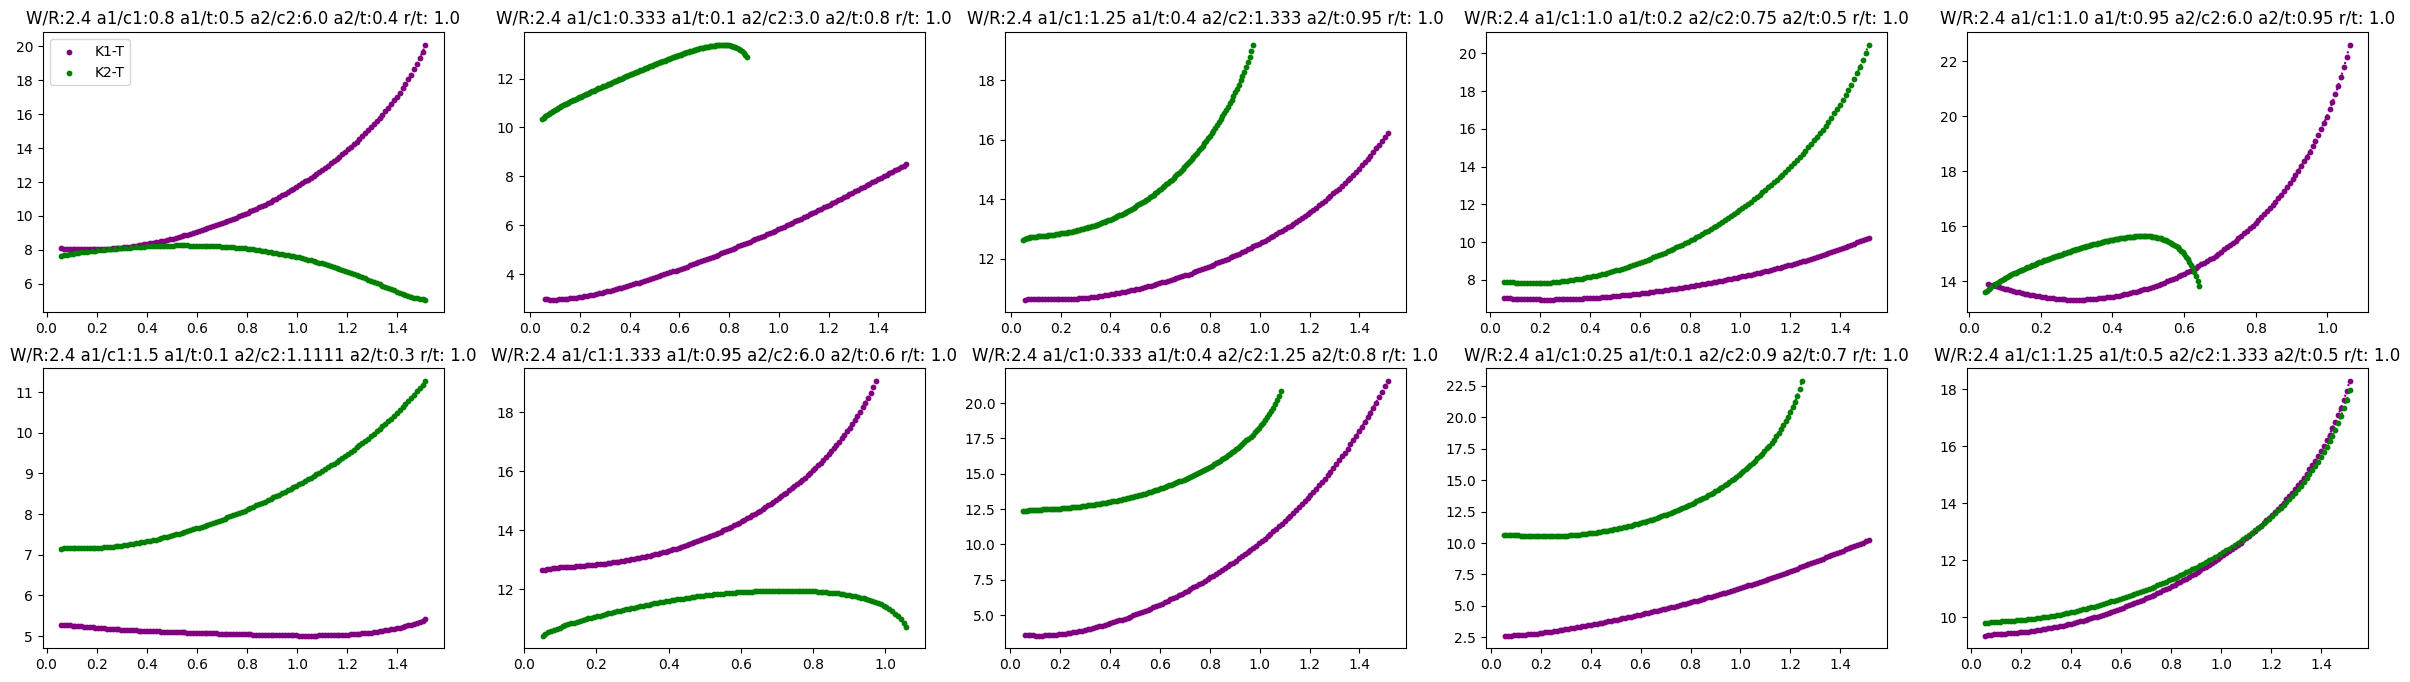

In [52]:
np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(30,8))
unique_index = np.unique(d_final[:,0])
print(len(unique_index))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(unique_index))
        data = d_final[idx*128:idx*128+128]
        W_R = np.unique(data[:,1])
        a1_c1 = np.unique(data[:,2])
        a1_t = np.unique(data[:,3])
        a2_c2 = np.unique(data[:,4])
        a2_t = np.unique(data[:,5])
        r_t = np.unique(data[:,6])

        assert len(W_R) == 1, W_R
        assert len(a1_c1) == 1
        assert len(a1_t) == 1
        assert len(a2_c2) == 1
        assert len(a2_t) == 1
        assert len(r_t) == 1

        axs[i,j].scatter(data[:,8], data[:,10], label="K1-T", color='purple', s=10)
        axs[i,j].plot(data[:,8], data[:,10], color='purple', linestyle=":")

        axs[i,j].scatter(data[:,9], data[:,11], label="K2-T", color='green', s=10)
        axs[i,j].plot(data[:,9], data[:,11], color='green', linestyle=":")

        axs[i,j].set_title("W/R:{} a1/c1:{} a1/t:{} a2/c2:{} a2/t:{} r/t: {}".format(W_R[0],
                                                                              a1_c1[0],
                                                                              a1_t[0],
                                                                              a2_c2[0],
                                                                              a2_t[0],
                                                                              r_t[0]))
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()